# Thông tin

MSSV: 20424037

Họ và tên: Trần Tuấn Huy

### Báo cáo mô tả các thuật toán đã cài đặt và giải thích các vấn đề của thuật toán Shamir cho số nguyên và tại sao áp dụng trường hữu hạn lại giải quyết các vấn đề đó được ghi trong file noteboook này

In [1]:
# Cài đặt các thư viện cần thiết
!pip install numpy
!pip install galois

import numpy as np
from PIL import Image
import galois
import scipy

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


## Thuật toán Shamir để chia sẽ thông tin mật là một con số nguyên S

Bài toán chia một thông tin mật S là một số nguyên thành n phần, sao cho:
- Với ít nhất là k phần bất kỳ (k ≤ n) thì sẽ tái tạo được S
- Với ít hơn k phần thì sẽ không biết gì về S

Mô tả thuật toán Shamir. Thuật toán gồm hai quá trình:

1. Phân chia thông tin mật từ thông tin mật S, số phần cần chia n và ngưỡng tái tạo k:
    - Tạo đa thức f là đa thức bậc k - 1, sao cho f(0) = S:$$f(x) = a_{k-1} x^{k-1} + a_{k-2} x^{k-2} + ... + a_{1} x ^ 1 + S$$
    - Từ đa thức f, chia n mảnh: $$S_1 = (1, f(1)), S_2 = (2, f(2)), ... , S_n = (n, f(n)) $$
2. Tái tạo thông tin mật từ n' phần, với n' >= k:
    - Tái tạo đa thức f (bậc k - 1) từ k phần tử trong n' phần (*)
    - Tính S từ giá trị f(0) của đa thức được tái tạo

(*) Ta có thể tái tạo đa thức f bậc k - 1, đi qua k điểm bằng cách sử dụng nột suy Lagrange
$$f(x) = f(x_1) \delta_{x_1}(x) + f(x_2) \delta_{x_2}(x) + ... +f(x_k) \delta_{x_k}(x)  $$

Trong đó:  
$$\delta_{xi}(x) = \left\{ 
  \begin{array}{ c l }
    1 & \quad \textrm{nếu } x = x_i \\
    0 & \quad \textrm{nếu } x \in \left\{ x_1, ... , x_k \right\} - \left\{ x_i \right\} \\ 
    \textrm{sao cũng được trong những trường hợp khác}
  \end{array}
\right.$$

$$ \delta_{xi}(x) = \frac{x - x_1}{x_i - x_1} \frac{x - x_2}{x_i - x_2} ... \frac{x - x_{i-1}}{x_i - x_{i-1}}\frac{x - x_{i+1}}{x_i - x_{i+1}} ... \frac{x - x_{k}}{x_i - x_{k}}
$$

In [2]:
def polynomial(xs: np.ndarray, coefs: np.ndarray):
    '''
    Hàm tính các giá trị một đa thức, có n hệ số

    Input:
        xs (mảng 1 chiều): Các giá trị x mà tại đó cần tính f(x).
        coefs (mảng 1 chiều): Các hệ số của đa thức.

    Output:
        mảng 1 chiều: các giá trị f(x) tương ứng với xs
    '''
    f_xs = np.zeros(xs.shape)
    n = len(coefs)
    # f(x) = coefs[0] + coefs[1]*x + coefs[2]*x^2 + ... + coefs[n - 1]*x^(n-1)
    for i in range(n):
        f_xs +=  coefs[i] * (xs ** i)
    return f_xs

def lagrange_interpolation(xs, ys, x):
    '''
    Hàm tính nội suy Lagrange

    Input:
        xs, ys (2 mảng 1 chiều): ys[i] = f(xs[i]).
        x (float): Giá trị x mà tại đó cần tính f(x) bằng nội suy Lagrange.

    Output:
        float: Giá trị f tại x
    '''
    f_x = 0
    for i in range(len(xs)):
        delta = 1
        for j in range(len(xs)):
            if j != i:
                delta *= (x - xs[j]) / (xs[i] - xs[j])
        f_x += ys[i] * delta
    
    return f_x

In [3]:
class Shamir:
    # Cài đặt thuật toán Shamir
    def __init__(self, S: int, n: int, k: int) -> None:
        '''
        Khởi tạo các giá trị của bài toán

        Input:
            S (int): thông tin mật cần chia
            n (int): số mảnh cần chia
            k (int): số phần tử cần để tái tạo tin mật
        '''
        self.S = S
        self.n = n
        self.k = k

    def split(self):
        '''
        Phương thức để chia tin mật thành n phần, 

        Output:
            xs, ys (2 mảng 1 chiều): 
                giá trị của các phần được phân chia, với phần thứ i là (xs[i], ys[i] = f(xs[i]))
                và f là đa thức bậc k - 1, có k hệ số
            coefs (mảng 1 chiều): các hệ số của đa thức f
        '''
        # Tạo k hệ số, hệ số đầu tiên là S để f(0) = S
        coefs = np.random.randint(-10, 10, self.k)
        coefs[0] = self.S
        # Tạo mảng xs từ 1 đến n
        xs = np.arange(self.n) + 1
        # Tính giá trị ys[i] = f(xs[i]) tương ứng với xs
        ys = polynomial(xs, coefs)
        return xs, ys, coefs

    def split_float(self):
        '''
        Phương thức để chia tin mật thành n phần, với các hệ số thực

        Output:
            xs, ys (2 mảng 1 chiều): 
                giá trị của các phần được phân chia, với phần thứ i là (xs[i], ys[i] = f(xs[i]))
                và f là đa thức bậc k - 1, có k hệ số
            coefs (mảng 1 chiều): các hệ số của đa thức f
        '''
        # Tạo k hệ số thực, hệ số đầu tiên là S để f(0) = S
        coefs = np.random.uniform(-10, 10, self.k)
        coefs[0] = self.S
        # Tạo mảng xs từ 1 đến n
        xs = np.arange(self.n) + 1
        # Tính giá trị ys[i] = f(xs[i]) tương ứng với xs
        ys = polynomial(xs, coefs)
        return xs, ys, coefs

    def join_lagrange_interpolation(self, xs, ys):
        '''
        Phương thức để tái tạo tin mật S từ các phần của tin mật (số phần >= k) bằng nột suy Lagrange

        Input:
            xs, ys (2 mảng 1 chiều): 
                giá trị của các phần, với phần thứ i là (xs[i], ys[i] = f(xs[i]))
                và f là đa thức bậc k - 1, có k hệ số
        
        Output:
            Tin mật S được tái tạo, trong trường hợp không đủ số phần để tái tạo tin mật thì trả về None.
        '''
        # Kiểm tra số lượng phần tử tái tạo tin mật
        if len(xs) < self.k:
            return None
        # Tính nội suy lagrange tại f(0) => S
        S = lagrange_interpolation(xs[:self.k], ys[:self.k], 0)
        return S

    # def join_cramer(self, xs, ys):
    #     A = x_polynomial_matrix(xs, self.k)
    #     b = ys.T
    #     x = np.dot(np.linalg.inv(A), b)
    #     return x[0]
    

In [4]:
# Khởi tạo thuật toán
S = 100
k = 3
n = 5
shamir = Shamir(S,n,k)
# Phân chia tin mật
xs, ys, coefs = shamir.split()
print(xs, ys, coefs[0])
# Phục hồi tin mật bằng Lagrange
print(
    # k - 1 phần
    shamir.join_lagrange_interpolation(xs[0:k -1],ys[0:k -1]),
    # k phần 
    shamir.join_lagrange_interpolation(xs[0:k],ys[0:k]),
    # k phần
    shamir.join_lagrange_interpolation(xs[1:k+1],ys[1:k+1])
)

[1 2 3 4 5] [107. 116. 127. 140. 155.] 100
None 100.0 100.0


## Các vấn đề của thuật toán Shamir:

- Bị tràn số khi chia quá nhiều phần (bậc của đa thức quá lớn)
- Tính toán với số thực không chính xác (máy tính không thể biểu diễn số thực chính xác)

In [5]:
# Overflow
shamir2 = Shamir(100,20,15)
xs, ys, coefs = shamir2.split()
print(shamir2.join_lagrange_interpolation(xs[0:15],ys[0:15]))
# Số thực không chính xác
shamir3 = Shamir(100,10,9)
xs, ys, coefs = shamir3.split_float()
print(shamir3.join_lagrange_interpolation(xs[1:10],ys[1:10]))

17265768530020.0
99.99999809265137


- Ngoài ra Shamir còn gặp một vấn đề liên quan đến bảo mật, đó là với k' phần (k' < k>) và dạng hàm số (bậc k), ta có thể thực hiện brute force để suy ra các phần còn lại để giải được tin mật.

## Áp dụng trường hữu hạn để cải tiến thuật toán Shamir

Số thực là một trường có vô số phần tử

Một trường (field) là một tập hợp mà trên đó:
- Các phép cộng, trừ (cộng với số ngược dấu), nhân, chia (nhân với số nghịch đảo) được định nghĩa (kết quả của những phép tính này cũng phải nằm trong tập hợp của trường → có tiềm năng để tránh vấn đề tràn số)
- Có tính chất như những phép tính trên số thực

=> Trường hữu hạn có thể giúp thuật toán Shamir có thể tính toán và biễu diễn chính xác kết quả, đồng thời khiến cho việc đoán được khó hơn vì kết quả sẽ tuần hoàn trong trường hữu hạn thay vì nằm trên hàm số f.

In [6]:
# Định nghĩa các phép toán trên trường hữu hạn Z_p
def polynomial_p(p, xs: np.ndarray, coefs: np.ndarray):
    # Hàm tính giá trị đa thức trong trường hữu hạn
    f_xs = np.zeros(xs.shape, dtype=int)
    n = len(coefs)
    for i in range(n):
        xs_pow_i = np.ones(xs.shape, dtype=int)
        for j in range(i):
            xs_pow_i = (xs_pow_i * xs) % p
        f_xs = (f_xs + coefs[i] * xs_pow_i % p) % p
    return f_xs

def compute_inv_p(p, x):
    # Hàm tính nghịch đảo trong trường hữu hạn
    for i in range(p):
        if i * x % p == 1:
            return i
    return None

def lagrange_interpolation_p(p, xs, ys, x):
    # Hàm tính nội suy Lagrange trong trường hữu hạn
    f_x = 0
    for i in range(len(xs)):
        delta = 1
        for j in range(len(xs)):
            if j != i:
                delta = delta * (((x - xs[j]) % p) * compute_inv_p(p, (xs[i] - xs[j]) % p) % p) % p
        f_x = (f_x + ys[i] * delta % p) % p
    return f_x

In [7]:
class ShamirP:
    # Cài đặt thuật toán Schamir trong trường hữu hạn
    def __init__(self, S: int, n: int, k: int, p: int) -> None:
        '''
        Khởi tạo các giá trị của bài toán trong trường hữu hạn Z_p

        Input:
            S (int): thông tin mật cần chia
            n (int): số mảnh cần chia
            k (int): số phần tử cần để tái tạo tin mật
            p (int): giá trị của trường hữu hạn, là số nguyên tố
        '''
        self.S = S
        self.n = n
        self.k = k
        self.p = p

    def split(self):
        # Tạo k hệ số trong trường hữu hạn, hệ số đầu tiên là S để f(0) = S
        coefs = np.random.randint(0, self.p, self.k)
        coefs[0] = self.S
        # Tạo mảng xs từ 1 đến n
        xs = np.arange(self.n) + 1
        # Tính giá trị ys[i] = f(xs[i]) tương ứng với xs trong trường hữu hạn
        ys = polynomial_p(self.p, xs, coefs)
        return xs, ys, coefs

    def join_lagrange_interpolation(self, xs, ys):
        # Kiểm tra số lượng phần tử tái tạo tin mật
        if len(xs) < self.k:
            return None
        # Tính nội suy lagrange tại f(0) => S trong trường hữu hạn
        S = lagrange_interpolation_p(self.p, xs[:self.k], ys[:self.k], 0)
        return S
    

In [8]:
# Khởi tạo thuật toán
S = 100
k = 3
n = 5
p = 101
shamir = ShamirP(S,n,k, 101)
# Phân chia tin mật
xs, ys, coefs = shamir.split()
print(xs, ys, coefs[0])
# Phục hồi tin mật bằng Lagrange trong trường hữu hạn
print(
    # k - 1 phần
    shamir.join_lagrange_interpolation(xs[0:k -1],ys[0:k -1]),
    # k phần 
    shamir.join_lagrange_interpolation(xs[0:k],ys[0:k]),
    # k phần
    shamir.join_lagrange_interpolation(xs[1:k+1],ys[1:k+1])
)

[1 2 3 4 5] [75 54 37 24 15] 100
None 100 100


## Cài đặt phương pháp chia sẽ ảnh mật bằng thuật toán Thiên & Lin với 2 phiên bản: Lossy và lossless

Bài toán chia sẻ ảnh thật, Chia ảnh mật $I$ (ảnh xám, mỗi pixel là một số nguyên ∈ [0, 255]) thành n phần $I1 ,I2, ... ,In$ sao cho:

- Với ít nhất là k phần bất kỳ (k ≤ n) thì sẽ tái tạo được I
- Với ít hơn k phần thì sẽ không biết gì về I

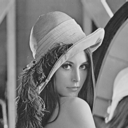

In [9]:
# Hàm tạo ma trận hệ số từ vector x
def gen_matrix(xs):
    '''
    Input: [1,2,3,4]
    Output:
        [
            x^0 x^1 x^2 x^3
            [1,  1,  1,  1]
            [1,  2,  4,  16]
            [1,  3,  9,  27]
            [1,  4,  16, 64]
        ]
    '''
    t = np.array([], dtype=int)
    k = xs.shape[0]
    for i in range(k):
        r = np.array([], dtype=int)
        x = xs[i]
        for j in range(k):
            r = np.append(r, [x ** j])
        t = np.append(t, r)
    return t.reshape((k, k))

# Chuẩn bị ảnh mật
size = (128,128)
img = Image.open('lena.bmp').resize(size)
image = np.array(img)
flat_image = image.flatten()
flat_image.shape
img

## Lossy Thiên & Lin 

#### Quá trình phân chia ảnh

Sử dụng trường hữu hạn $Z_p$ với p = 251, với các pixel có giá trị > 250 đặt thành 250

Duyệt k pixel một lần, với mỗi nhóm k pixel $p_1, p_2, ..., p_k$:
- Ta có được đa thức $f(x) = p_1 + p_2 x + ... + p_k x^{k-1}$
- Giá trị k pixel của nhóm sẽ được chia thành n phần theo Schamir

=> Từ tất cả phần thứ i của các nhóm, ta thu được phần ảnh $I_i$ được chia nhỏ

#### Quá trình tái tạo ảnh

Trong n' phần ảnh $I_i$ được phần ra, ta cần k phần để tái tạo ảnh mật
- Duyệt theo nhóm pixel, với mỗi lần duyệt tái tạo lại đa thức $f(x)$ bậc k - 1 từ k giá trị cùng nhóm pixel, từ đó thu được k hệ số của đa thức chính là k pixel của ảnh mật (*)
- Sau khi thu được tất cả pixel của các nhóm, ta có thể tái tạo được ảnh mật.

(*) Ta có thể tìm hệ số của đa thức $f(x) = p_1 + p_2 x + ... + p_k x^{k-1}$ bậc k - 1 đi qua k điểm xác định, bằng cách giải một hệ phương trình tuyến tính:
$$\begin{bmatrix}
x_1^0 & x_1^1 & ... & x_1^k\\
x_2^0 & x_2^1 & ... & x_2^k\\
... & ... & ... & ... \\
x_n^0 & x_n^1 & ... & x_n^k\\
\end{bmatrix} 
\begin{bmatrix} p_1 \\ p_2 \\ ...\\ p_n \end{bmatrix} = \begin{bmatrix} y_1 \\ y_2 \\ ...\\ y_n \end{bmatrix}$$


In [10]:
class ThienLinLossy:
    # Cài đặt thuật toán Lossy
    def __init__(self, S: np.ndarray, n: int, k: int) -> None:
        # Khởi tạo bài toán
        self.S = np.copy(S)
        # Đặt các giá trị > 250 thành 250
        self.S[self.S > 250] = 250

        self.n = n
        self.k = k
        self.p = 251

    # Hàm phân chia thành n phần
    def split(self):
        group_xs = []
        group_ys = []
        group_coefs = []
        n_p = self.S.shape[0]

        # Duyệt theo nhóm k pixels, chia từng nhóm thành n phần
        for c in range(0, n_p, self.k):
            # k hệ số tương ứng với k pixels trong nhóm
            coefs = self.S[c: c + self.k]
            # giá trị x từ 1 đến n
            xs = np.arange(self.n) + 1
            # giá trị y = f(x) tương ứng
            ys = polynomial_p(self.p, xs, coefs)

            group_coefs.append(coefs)
            group_xs.append(xs)
            group_ys.append(ys)

        return np.array(group_xs), np.array(group_ys), np.array(group_coefs, dtype=object)

    # Hàm tái tạo từ k mảnh
    def join_cramer(self, Ixs, Iys):
        g_k, i_n = Ixs.shape
        # Nếu ít hơn k mảnh trả về None
        if g_k < self.k:
            return None

        # Trường hữu hạn Z_251
        GF251 = galois.GF(251 ** 1)
        xs = Ixs[0, 0: self.k]
        # Ma trận giá trị x trong trường hữu hạn
        X = GF251(gen_matrix(xs))

        pixels = np.array([], dtype=np.uint8)
        # Duyệt theo từng nhóm pixel trong k mảnh
        for i in range(g_k):
            # Mảng các giá trị f(x) trong trường hữu hạn
            ys = GF251(Iys[i, 0: self.k])
            # Giải phương trình tuyến tính trong trường hữu hạn, thu được k pixels trong nhóm i
            g_p = np.linalg.solve(X, ys)
            # Thêm kết quả vào mảng chứa tất cả pixels của ảnh 
            pixels = np.append(pixels, g_p)
        
        return pixels

True


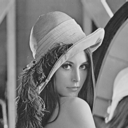

In [11]:
k = 4
tllossy = ThienLinLossy(flat_image, 6, k)
Ixs, Iys, Icoefs = tllossy.split()

# Tái tạo từ k mảnh đầu tiên
restore_flat_img = tllossy.join_cramer(Ixs[:,0:k], Iys[:,0:k])
restore_img = np.array(restore_flat_img, dtype=np.uint8).reshape(size)
# So sảnh kết quả thu được
print(np.all(image == restore_img))
Image.fromarray(restore_img)

True


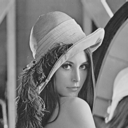

In [12]:
# k mảnh cuối cùng 
restore_flat_img = tllossy.join_cramer(Ixs[:,2:6], Iys[:,2:6])
restore_img = np.array(restore_flat_img, dtype=np.uint8).reshape(size)
# So sảnh kết quả thu được
print(np.all(image == restore_img))
Image.fromarray(restore_img)

## Lossless Thiên & Lin 

### Quá trình phân chia

Giống như lossy, nhưng tách các giá trị x > 250 thành 2 phần là 250 và x - 250, đồng thời sử dụng một mảng khác để chứa các giá trị đã tách và thực hiện phân chia trên mảng này

### Quá trình tái tạo

Theo các bước như lossy, ta sẽ thu được giá trị pixel trong mảng khác, duyệt trong mảng khác ta sẽ thu được các phần tử pixel của ảnh:
- Nếu phần tử mảng khác không bằng 250, ghi nhận giá trị
- Nếu phần tử mảng khác bằng 250, lấy tiếp phần tử kế và ghi nhận giá trị

In [13]:
# Hàm duyệt mảng khác để cho ra giá trị ảnh
def real_pixels(pixels):
    r_p = []
    pre = 0
    for p in np.array(pixels):
        if p != 250:
            r_p.append(p + pre)
            pre = 0
        else:
            pre = p
    return np.array(r_p)

In [14]:
class ThienLinLossless:
    # Cài đặt thuật toán Lossless
    def __init__(self, S: np.ndarray, n: int, k: int) -> None:
        temp = []
        for i in S:
            v = min(250, i)
            temp.append(v)
            if v == 250:
                temp.append(i - 250)
        self.S = np.array(temp)

        self.n = n
        self.k = k
        self.p = 251

    # Hàm phân chia thành n phần
    def split(self):
        group_xs = []
        group_ys = []
        group_coefs = []
        n_p = self.S.shape[0]

        # Duyệt theo nhóm k pixels, chia từng nhóm thành n phần
        for c in range(0, n_p, self.k):
            # k hệ số tương ứng với k pixels trong nhóm
            coefs = self.S[c: c + self.k]
            # giá trị x từ 1 đến n
            xs = np.arange(self.n) + 1
            # giá trị y = f(x) tương ứng
            ys = polynomial_p(self.p, xs, coefs)

            group_coefs.append(coefs)
            group_xs.append(xs)
            group_ys.append(ys)

        return np.array(group_xs), np.array(group_ys), np.array(group_coefs, dtype=object)

    # Hàm tái tạo từ k mảnh
    def join_cramer(self, Ixs, Iys):
        g_k, i_n = Ixs.shape
        # Nếu ít hơn k mảnh trả về None
        if g_k < self.k:
            return None

        # Trường hữu hạn Z_251
        GF251 = galois.GF(251 ** 1)
        xs = Ixs[0, 0: self.k]
        # Ma trận giá trị x trong trường hữu hạn
        X = GF251(gen_matrix(xs))

        pixels = np.array([], dtype=np.uint8)
        # Duyệt theo từng nhóm pixel trong k mảnh
        for i in range(g_k):
            # Mảng các giá trị f(x) trong trường hữu hạn
            ys = GF251(Iys[i, 0: self.k])
            # Giải phương trình tuyến tính trong trường hữu hạn, thu được k pixels trong nhóm i
            g_p = np.linalg.solve(X, ys)
            # Thêm kết quả vào mảng chứa tất cả pixels của ảnh 
            pixels = np.append(pixels, g_p)
        
        return pixels

True


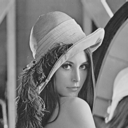

In [15]:
k = 4
tllossless = ThienLinLossless(flat_image, 6, k)
Ixs, Iys, Icoefs = tllossless.split()

# Tái tạo từ k mảnh đầu tiên
temp_restore_flat_img = tllossless.join_cramer(Ixs[:,0:k], Iys[:,0:k])
# Từ mảng khác tạo lại mảng các pixels
restore_flat_img = real_pixels(temp_restore_flat_img)

# So sánh kết quả
restore_img = np.array(restore_flat_img, dtype=np.uint8).reshape(size)
print(np.all(image == restore_img))
Image.fromarray(restore_img)